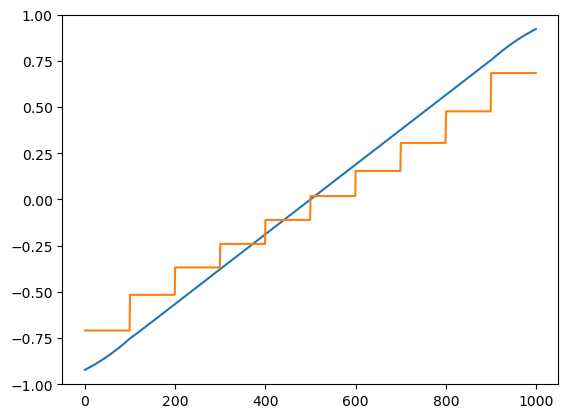

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import math

def random_walk_true_value(num_states, num_groups, trans_len):
    trans_prob = 0.5 / trans_len

    order = num_states
    i = np.identity(order)
    t = np.zeros_like(i)
    for row in range(order):
        for col in range(order):
            dis = row - col
            if dis >= -trans_len and dis <= trans_len and dis != 0:
                t[row][col] = trans_prob

    b = np.zeros(order)
    for row in range(order):
        for n in range(trans_len):
            if row - n - 1 < 0:
                b[row] -= trans_prob
            if row + n + 1 >= order:
                b[row] += trans_prob
    m = i - t
    s = np.linalg.solve(m,b)
    return s


class RandomWalk:
    def __init__(self, num_states, num_groups, trans_len):
        self.num_states = num_states
        self.num_groups = num_groups
        self.trans_len = trans_len
        self.state = self.num_states // 2
       
    def reset(self):
        self.state = self.num_states // 2
        return self.state

    def step(self):
        offset = np.random.randint(-self.trans_len, self.trans_len)
        if offset >=0:
            offset += 1
        self.state += offset
        if self.state < 0:
            return -1, self.num_states
        elif self.state < self.num_states:
            return 0, self.state
        else:
            return 1, self.num_states
        
    def is_terminated(self, state):
        return state >= self.num_states

class StateAggregation:
    def __init__(self, env):
        self.num_states = env.num_states
        self.num_groups = env.num_groups
        self.w = np.zeros(self.num_groups)

    def aggregated_state(self, state):
        return state * self.num_groups // self.num_states

    def predicate(self, state):
        agg_state = state * self.num_groups // self.num_states
        return self.w[agg_state]
    
    def train(self, state, target, alpha):
        agg_state = self.aggregated_state(state)
        v_hat = self.w[agg_state]
        self.w[agg_state] += (target - v_hat) * alpha

def semi_gradient_td(env, approximator, num_episodes, alpha, gamma = 1.0):
    for episode in range(num_episodes):
        state = env.reset()
        while True:
            reward, next_state = env.step()
            is_terminated = env.is_terminated(next_state)
            v_prime = 0 if is_terminated else approximator.predicate(next_state) 
            approximator.train(state, reward + v_prime * gamma, alpha)
            if is_terminated:
                break
            state = next_state

def semi_gradient_n_step_td(env, approximator, n_step, num_episodes, alpha, gamma = 1.0):
    rewards = np.zeros(n_step, dtype=float)
    states = np.zeros(n_step, dtype=int)
    for episode in range(num_episodes):
        state = env.reset()
        terminated = False
        reward_count = n_step
        t = 0
        while True:
            if not terminated:
                reward, next_state = env.step()
                terminated = env.is_terminated(next_state)
                states[t%n_step] = state
                rewards[t%n_step] = reward
                state = next_state
                terminated_t = t 
            elif t >= terminated_t + n_step:
                break

            if t + 1 >= n_step:
                tao = t + 1 - n_step
                last_reward_t = terminated_t if terminated else t
                v_prime = 0 if terminated else approximator.predicate(next_state) 
                g = v_prime * gamma + reward
                for i in range(last_reward_t - 1, tao - 1, -1):
                    g = g * gamma + rewards[i%n_step]
                s_tao = states[tao%n_step]
                approximator.train(s_tao, g, alpha)
            t += 1


num_states = 1000
num_groups = 10
trans_len = 100
true_value = random_walk_true_value(num_states, num_groups, trans_len)
env = RandomWalk(num_states, num_groups, trans_len)
approximator = StateAggregation(env)
semi_gradient_td(env, approximator, 10000, 1e-3)

v_hats = np.zeros(env.num_states)
for s in range(env.num_states):
    v_hats[s] = approximator.predicate(s)

plt.ylim((-1,1))
plt.plot(range(len(true_value)),true_value)
plt.plot(range(len(v_hats)), v_hats)




num_states = 1000
num_groups = 20
trans_len = 100
true_value = random_walk_true_value(num_states, num_groups, trans_len)
env = RandomWalk(num_states, num_groups, trans_len)
approximator = StateAggregation(env)


params=[
    [1, [], "#FF0000"],
    [2, [], "#00FF00"],
    [4, [], "#0000FF"],
    [8, [], "#000000"],
    [16, [], "#FF00FF"],
    [32, [], "#00FFFF"],
    [64, [], "#800080"],
    [128, [], "#FF00FF"],
    [256, [], "#FF8000"],
    [512, [], "#008000"],
]

plt.ylim((0.1,0.55))

repetition = 1
alphas = [math.exp(i/10) for i in range(-50, 1, 1)]

for param in params:
    step = param[0]
    rmses = param[1]
    for alpha in alphas:
        rmse = 0
        for run in range(repetition):
            vs = semi_gradient_n_step_td(env, approximator, step, 10, alpha)
            rmse += np.sqrt(np.power((vs - true_values),2.0).mean())
        rmses.append(rmse/repetition)

for param in params:
    rmses = param[1]
    color = param[2]
    plt.plot(alphas, rmses, color, linewidth = 0.5)